In [1]:
% matplotlib inline

import pandas as pd, numpy as np
import seaborn as sns
import utils.stats as stats
import utils.viz as viz
import statsmodels.formula.api as smf
from scipy.stats import spearmanr, pearsonr
import utils.viz as viz
from scipy.stats import shapiro
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set_context('poster')

## Functional data

In [2]:
df_func = pd.read_pickle('./data/df_func.pkl')

In [3]:
df_func.columns = ['area', 'condist', 'primdist', 'residual', 'studentized residual', 
                   'p-value', 'Bonferroni corrected p-value']
df_func = df_func[['area', 'primdist', 'condist', 'residual', 'studentized residual', 
                   'p-value', 'Bonferroni corrected p-value']]

df_func['type'] = 'functional'

df_func.head()

,area,primdist,condist,residual,studentized residual,p-value,Bonferroni corrected p-value,type
0,1,2.528949,14.341857,-0.969252,-0.292951,0.770249,1.0,functional
1,10,33.739209,20.929880,-0.191816,-0.059098,0.953008,1.0,functional
2,11,29.399108,20.747677,0.434002,0.132005,0.895281,1.0,functional
3,12,18.702659,17.138424,-1.183834,-0.354108,0.724105,1.0,functional
4,13,24.760185,17.193634,-2.256387,-0.681214,0.497525,1.0,functional


In [4]:
d = {'29/30': '29_30',
     '9/46d': '9_46d',
     '9/46v': '9_46v',
     'ENTORHINAL': 'Ento',
     'INSULA': 'Ins',
     'OPRO': 'Opro',
     'PERIRHINAL': 'Peri',
     'PIRIFORM': 'Pir',
     'Parainsula': 'Pi',
     'Pro.St': 'Pro.',
     'SII': 'S2',
     'SUBICULUM': 'Sub',
     'TEMPORAL_POLE': 'TEMPORAL-POLE',
     'TEa/ma': 'TEa_m-a',
     'TEa/mp': 'TEa_m-p',
     'CORE': 'Core'}

df_func.replace({'area':d}, inplace=True)

## Structural data

In [5]:
df_struct = pd.read_pickle('./data/df_struct.pkl')

df_struct = df_struct[['area', 'dist_inj_prim', 'corrected_condist', 
                       'struct_resid', 'struct_stud_resid', 'struct_unadj_p', 'struct_bonf_p']]

df_struct.columns = ['area', 'primdist', 'condist', 'residual', 'studentized residual', 
                     'p-value', 'Bonferroni corrected p-value']

df_struct['type'] = 'structural (corrected)'
df_struct.head()

,area,primdist,condist,residual,studentized residual,p-value,Bonferroni corrected p-value,type
0,V2,1.760742,20.734801,2.024793,0.720136,0.478397,1.0,structural (corrected)
1,V3,NaN,NaN,NaN,NaN,NaN,NaN,structural (corrected)
2,V3A,NaN,NaN,NaN,NaN,NaN,NaN,structural (corrected)
3,V4,9.414062,17.658157,-1.654389,-0.530614,0.600562,1.0,structural (corrected)
4,V4t,NaN,NaN,NaN,NaN,NaN,NaN,structural (corrected)


## Connectivity distance values (both)

In [6]:
# combine
df = pd.concat([df_func[df_func.area!='???'], df_struct])

In [7]:
condist = pd.pivot_table(df, index=['area'], columns='type', values='condist')
condist = condist.sort_index(ascending=False)

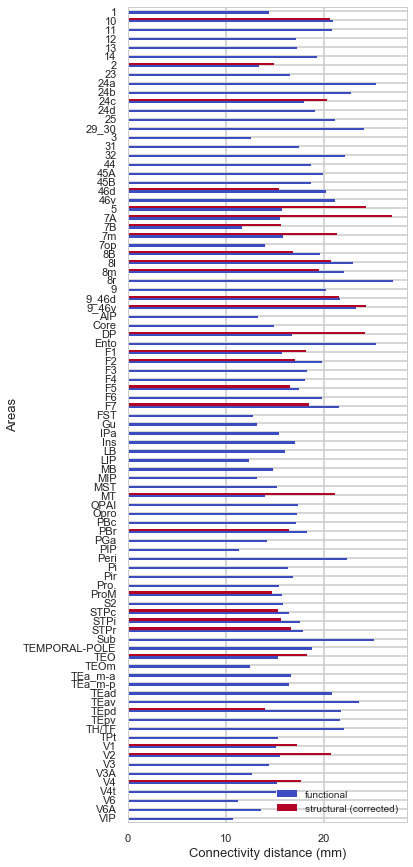

In [8]:
ax = condist.plot(kind='barh', figsize=(5, 15), fontsize=11, colormap='coolwarm')

_ = ax.set_ylabel('Areas', fontdict={'fontsize':13})
_ = ax.set_xlabel('Connectivity distance (mm)', fontdict={'fontsize':13})
_ = ax.legend(loc=4, fontsize=10)

#plt.savefig('/Users/sabine/Downloads/suppl_condist_vals.png', dpi=300)

## Residuals (both)

In [9]:
resid = pd.pivot_table(df, index=['area'], columns='type', values='studentized residual')
resid = resid.sort_index(ascending=False)

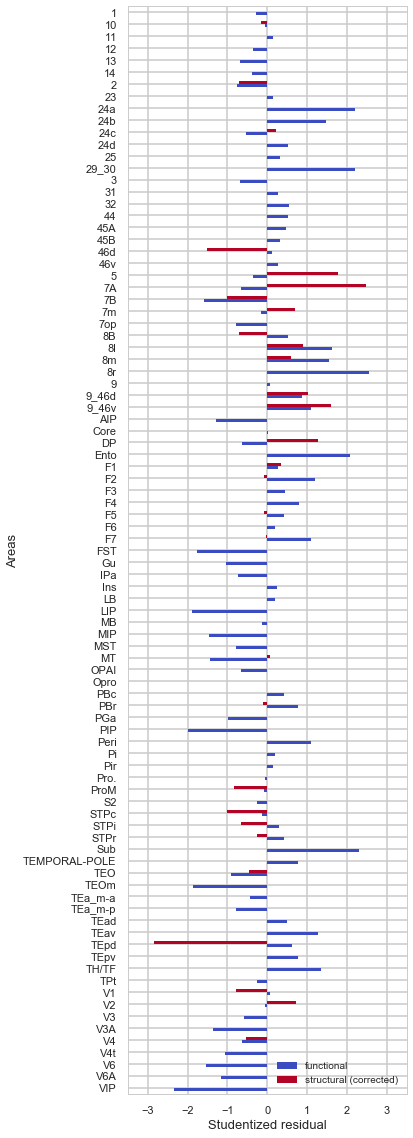

In [10]:
ax = resid.plot(kind='barh', figsize=(5, 20), fontsize=11, colormap='coolwarm')

_ = ax.set_ylabel('Areas', fontdict={'fontsize':13})
_ = ax.set_xlabel('Studentized residual', fontdict={'fontsize':13})
_ = plt.xlim([-3.5, 3.5])
_ = plt.xticks([-3, -2, -1, 0, 1, 2, 3])
_ = ax.legend(loc=4, fontsize=10)

#plt.savefig('/Users/sabine/Downloads/suppl_residuals.png', dpi=300)

## Comparison: Functional and structural connectivity distance

In [11]:
df = df_func[df_func.area!='???'].merge(df_struct, how='left', on='area', suffixes=['_func', '_struct'])

### Direct comparison

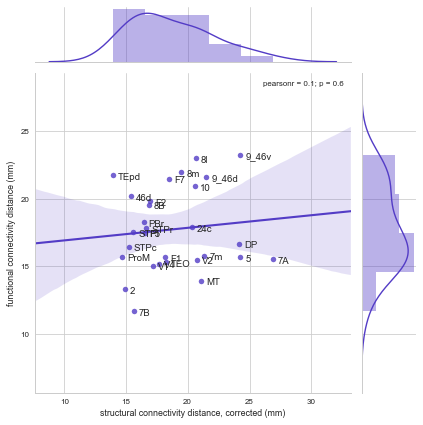

In [17]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.4, point['y']-.3, str(point['val']))#, size='xx-small')


g = sns.jointplot(x="condist_struct", 
                  y="condist_func", 
                  data=df[df.condist_struct.notnull()], 
                  kind='reg', 
                  color="#533cc6", 
                  stat_func=pearsonr,
                  scatter_kws={"s": 30})

plt.xlabel('structural connectivity distance, corrected (mm)')
plt.ylabel('functional connectivity distance (mm)')

label_point(df.condist_struct[df.condist_struct.notnull()], 
            df.condist_func[df.condist_struct.notnull()], 
            df.area[df.condist_struct.notnull()], 
            plt.gca()) 

g.savefig('/Users/sabine/Downloads/direct_comparison_func_struct.png', dpi=300)

### Indirect comparison (estimated whole-brain structural connectivity distance)

In [18]:
estimate = pd.read_pickle('/Users/sabine/Downloads/permutations/df_surf_normalized_rsqr.pkl')
estimate.head()

,node,area,rsqr
0,0,23,0.046957
1,1,V6A,-0.086314
2,2,2,0.038584
3,3,F1,0.086013
4,4,V1,0.057172


In [19]:
estimate = estimate.groupby('area').rsqr.mean().reset_index()
estimate['structural_estimate'] = estimate.rsqr

In [20]:
df = df.merge(estimate[['area', 'structural_estimate']], on='area', how='left')

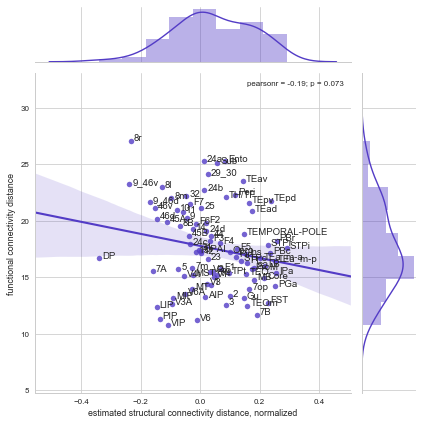

In [26]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.01, point['y'], str(point['val']))#, size='xx-small')


g = sns.jointplot(x="structural_estimate", 
                  y="condist_func", 
                  data=df[df.condist_func.notnull()], 
                  kind='reg', 
                  color="#533cc6",
                  stat_func=pearsonr,
                  scatter_kws={"s": 30})

plt.xlabel('estimated structural connectivity distance, normalized')
plt.ylabel('functional connectivity distance')


label_point(df.structural_estimate[df.condist_func.notnull()], 
            df.condist_func[df.condist_func.notnull()], 
            df.area[df.condist_func.notnull()], 
            plt.gca()) 

g.savefig('/Users/sabine/Downloads/indirect_comparison_func_struct.png', dpi=300)